In [1]:
import keras
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

Using TensorFlow backend.


In [2]:
labels=pd.read_csv('Desktop/MACHINE LEARNING PROJECT/dataset_AMLS_19-20/cartoon_set/labels.csv',delimiter='\t')
shape_label=labels['face_shape']

In [3]:
from imutils import face_utils
import argparse
import imutils
import dlib
import cv2

In [53]:
shapes=[]
landmarks=[]
other_marks=[]
for i in tqdm(range(shape_label.shape[0])):
    # initialize dlib's face detector (HOG-based) and then create
    # the facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('Desktop/shape_predictor_68_face_landmarks.dat')
    image = cv2.imread("Desktop/MACHINE LEARNING PROJECT/dataset_AMLS_19-20/cartoon_set/img/%d.png" %i)
    gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    detections = detector(gray, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(gray, d) #Draw Facial Landmarks with the predictor class
        xylist = []
        #ylist = []
        for j in range(0,17): #Store X and Y coordinates in two lists for jaw region
            xylist.append(float(shape.part(j).x))
            xylist.append(float(shape.part(j).y))
        if len(xylist)==34:
            landmarks.append(xylist)
            #landmarks.append(y)
            shapes.append(shape_label[i])
        xylist = []
        for k in range(17,68):
            xylist.append(float(shape.part(k).x))
            xylist.append(float(shape.part(k).y))
        if len(xylist)==102:
            other_marks.append(xylist)

        else: #If no faces are detected, return error message to other function to handle
            pass

100%|██████████| 10000/10000 [5:16:29<00:00,  1.90s/it] 


In [298]:
k=len(landmarks)
X=np.zeros((k,34))
for i in range(k):
    X[i][0:34]=landmarks[i][0:34]
    

In [299]:
k

8090

In [300]:
a=0
b=0
c=0
d=0
e=0
X0=np.zeros((k,34))
X1=np.zeros((k,34))
X2=np.zeros((k,34))
X3=np.zeros((k,34))
X4=np.zeros((k,34))
for i in range (k):
    if shapes[i]==0:
        X0[a][0:34]=X[i][0:34]
        a=a+1
    elif shapes[i]==1:
        X1[b][0:34]=X[i][0:34]
        b=b+1
    elif shapes[i]==2:
        X2[c][0:34]=X[i][0:34]
        c=c+1
    elif shapes[i]==3:
        X3[d][0:34]=X[i][0:34]
        d=d+1
    elif shapes[i]==4:
        X4[e][0:34]=X[i][0:34]
        e=e+1

X0=X0[~(X0==0).all(1)]
X1=X1[~(X1==0).all(1)]
X2=X2[~(X2==0).all(1)]
X3=X3[~(X3==0).all(1)]
X4=X4[~(X4==0).all(1)]

In [341]:
np.unique(shapes)

array([0, 1, 2, 3, 4])

In [416]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
faces=[0,1,2,3,4]
Xn=[X0,X1,X2,X3,X4]
A=[]
n_labs=[]
for face in faces:
    stscaler = StandardScaler().fit(Xn[face])
    data = stscaler.transform(Xn[face])
    dbscan = DBSCAN(eps = 4 , min_samples = 10)
    model=dbscan.fit(data)
    labels=model.labels_
    core_samples_mask = np.zeros_like(model.labels_, dtype=bool) 
    core_samples_mask[model.core_sample_indices_] = True
    #print(core_samples)
    n_clusters=len(set(labels))-(1 if -1 in labels else 0)
    print(n_clusters)
    labels1=[x for x in labels if x!=-1]
    class_member_mask = (labels == 0) 
    A.append(Xn[face][class_member_mask & core_samples_mask])    
    A.append(Xn[face][class_member_mask & ~core_samples_mask])
    n_labs.append(len(labels1))
    print(len(labels1))
    

1
1471
1
1459
1
1605
1
1532
1
1482


In [419]:
A=np.asarray(A)
Ak=A[3]
Ak.shape

(80, 34)

In [426]:
k=np.sum(n_labs)
X_new=np.zeros((k,35))
i=0
j=0
for lab in n_labs:
    X_new[i:i+lab,0]=int(j/2)
    Am=A[j]
    An=A[j+1]
    p=A[j].shape[0]
    for m in range(lab):
        for n in range(34):
            try:
                X_new[i+m][n+1]=Am[m][n]
            except:
                X_new[i+m][n+1]=An[m-p][n]
    j=j+2
    i=i+lab

In [427]:
np.random.shuffle(X_new)

In [428]:
X_new

array([[  0., 156., 239., ..., 267., 343., 243.],
       [  4., 165., 258., ..., 280., 333., 259.],
       [  0., 158., 255., ..., 278., 339., 255.],
       ...,
       [  1., 160., 251., ..., 275., 336., 253.],
       [  2., 162., 240., ..., 264., 335., 242.],
       [  0., 164., 266., ..., 287., 333., 267.]])

In [429]:
y=np.zeros(k)
x=np.zeros((k,34))
for i in range(X_new.shape[0]):
    y[i]=X_new[i][0]
    x[i,0:34]=X_new[i,1:35]
    
    

In [430]:
np.unique(y)

array([0., 1., 2., 3., 4.])

In [431]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.3)

In [432]:
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [433]:
scaler = MinMaxScaler() # This estimator scales and translates each feature individually such that it is in the given range on the training set, default between(0,1)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [434]:
hyper_para=[{'kernel':['rbf'],'gamma':[0.001, 0.01, 0.1, 1, 10 ,100],'C':[0.001, 0.01, 0.1, 1, 10 ,100,1000]}]
clf = GridSearchCV(estimator=svm.SVC(), param_grid=hyper_para,cv=5, n_jobs=-1)
clf.fit(X_train,y_train)
print('Best score:', clf.best_score_) 

Best score: 0.8088569265707797


In [435]:
print('Best C:',clf.best_estimator_.C) 
print('Best Gamma:',clf.best_estimator_.gamma)

Best C: 10
Best Gamma: 1


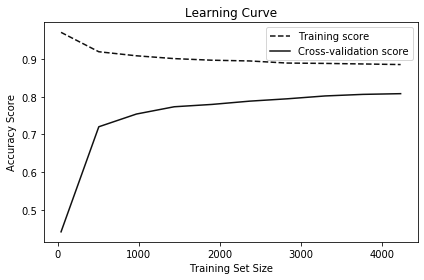

In [436]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(svm.SVC(C=10,kernel='rbf',gamma=1), 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 10 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [437]:
#SVM classifier 
def SVM(x_train,y_train, x_test):
    model = svm.SVC(C=10,kernel='rbf',gamma=1)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    return y_pred
# Scikit learn library results
y_pred=SVM(X_train,y_train, X_test)
print(accuracy_score(y_test,y_pred))

0.8211920529801324


/Users/aiswarya/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/aiswarya/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy on test set: 0.7094922737306844


/Users/aiswarya/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy on test set: 1.0


Accuracy on test set: 1.0


/Users/aiswarya/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/aiswarya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
